### This notebook will implement a simple backtester to illustrate the type of research that can be performed using historical VIX data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [10]:
# To be replaced with generated VIX series at some point:
vix = pd.read_csv('data/VIX.csv', header = 2)
spx = pd.read_csv('data/SPX.csv', header = 2)

# Drop columns and process dats
vix["VIX"] = vix.loc[:,'Close']
spx["SPX"] = spx.loc[:,'Close']
vix.drop(columns = ['Ticker', 'Open', 'Close'], axis=1, inplace=True)
spx.drop(columns = ['Ticker', 'Open', 'Close'], axis=1, inplace=True)
vix['Date'] = pd.to_datetime(vix['Date'])
spx['Date'] = pd.to_datetime(spx['Date'])


from functools import reduce
dfs = [vix, spx]
data = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='inner'), dfs)

In [11]:
data

,Date,VIX,SPX
0,1986-01-31,19.58,199.177702
1,1986-02-28,21.59,214.044573
2,1986-03-31,23.33,225.975794
3,1986-04-30,21.69,223.417280
4,1986-06-30,18.31,239.240669
...,...,...,...
8524,2021-10-15,16.30,9342.150000
8525,2021-10-18,16.31,9373.680000
8526,2021-10-19,15.70,9443.120000
8527,2021-10-20,15.49,9477.820000


In [79]:
class Call_Option:
    _strike = None
    _exp_date = None
    _int_rate = None
    
    def __init__(self, strike, exp_date, int_rate=0.01):
        self._strike = strike
        self._exp_date = exp_date
        self._int_rate = int_rate
        
    # Calculate time until expiration, as a fraction of a year
    def calc_tte(self, current_date):
        days_until_expiration = (exp_date - current_date.date()).days
        return (days_until_expiration / 365)
        
    # Calculate the current price of the option
    def price(self, current_date, current_price, current_ivol):
        tte = self.calc_tte(current_date)

        d1 = (np.log(current_price/self._strike) + tte*(self._int_rate + np.square(current_ivol)/2)) / \
            current_ivol * np.sqrt(tte)
        
        d2 = d1 - current_ivol * np.sqrt(tte)
        
        call_price = current_price * norm.cdf(d1) - self._strike*np.exp(-self._int_rate*tte) * \
        norm.cdf(d2)
        
        # Sell when there are less than 10 days until the option expires
        if tte < (10/365):
            time_to_sell = True
        else:
            time_to_sell = False
            
        
        if call_price < 1:
            print("strike: " + str(self._strike))
            print("c. price: " + str(current_price))
            print("tte: " + str(tte * 365))
        return call_price, time_to_sell

In [96]:
# Iterate through all days:
list_of_dates = []
reference_list_of_values = []
reference_value = 1
list_of_values = []
value = 1
allocation_to_options = 0.005
option_portfolio = []
option_portfolio_value = 0

for i, current_date in enumerate(data.iloc[30:].Date): # Start 30 days in
    i = i + 30
    current_vix = data.iloc[i].VIX
    current_price = data.iloc[i].SPX
    pct_change_in_SPX = (current_price - data.iloc[i-1].SPX) / data.iloc[i-1].SPX
    
    
    ##
    ## Update options portfolio value
    temp_val = 0
    temp_portfolio = []
    for option in option_portfolio:
        option_val, time_to_sell = option.price(current_date, current_price, current_ivol=current_vix)
        temp_val += option_val
        if time_to_sell == False:
            temp_portfolio += [option]
    
    
    # Calculate % change in price of options
    if len(option_portfolio) > 0 and option_portfolio_value > 0.01:
        pct_change_in_options_portfolio = (temp_val - option_portfolio_value) / option_portfolio_value
    else:
        # No return.
        pct_change_in_options_portfolio = 0
        
        
    # Update our options holdings (we may have sold some options)
    option_portfolio = temp_portfolio
        
    # Update value of options portfolio
    option_portfolio_value = temp_val
        
    # Weighted average of options position and SPX position
    pct_change_in_portfolio = allocation_to_options * pct_change_in_options_portfolio + \
                            (1-allocation_to_options) * pct_change_in_SPX
    
    # Update portfolio values
    value = value * (1 + pct_change_in_portfolio)
    reference_value = reference_value * (1+pct_change_in_SPX)
    
    
    ##
    ## Buy a new option, if conditions are met
    if len(option_portfolio) == 0:
        # See if we want to add a new options position
        # If SPX is up more than 1% over the last month:
        if (current_price - data.iloc[i-30].SPX) / data.iloc[i-30].SPX > 0.01:
            
            # Buy a call option at spot, 30 days out
            exp_date = current_date.date() + timedelta(days=30)
            new_option = Call_Option(strike=current_price, exp_date = exp_date)
            option_portfolio += [new_option]
            option_portfolio_value += new_option.price(current_date, current_price, current_vix)[0]
    
    
    list_of_dates += [current_date.date()]
    list_of_values += [value]
    reference_list_of_values += [reference_value]

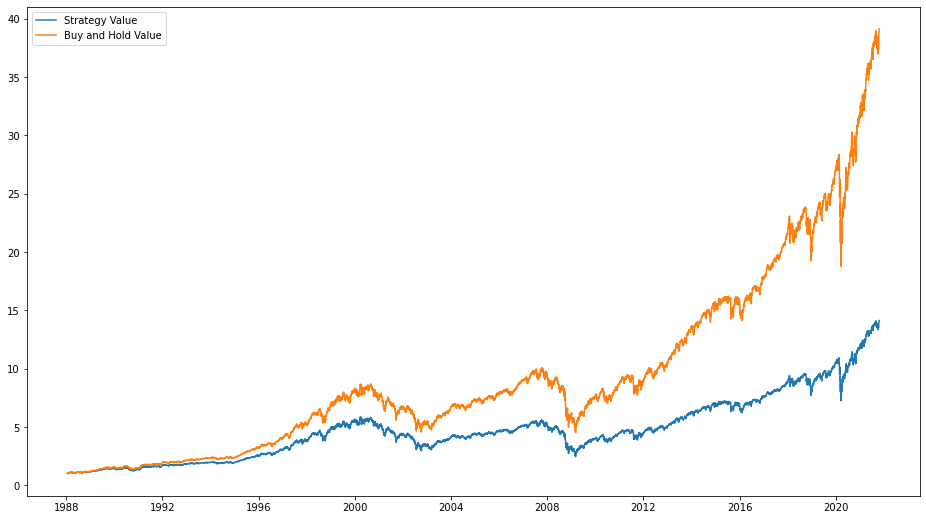

In [97]:
plt.figure(figsize=(16,9))
plt.plot(list_of_dates, list_of_values)
plt.plot(list_of_dates, reference_list_of_values)
plt.legend(["Strategy Value", "Buy and Hold Value"])
plt.show()

#### Take away: Allocating 0.5% of your portfolio to at-the-money call options, whenever the SPX has increased by more than 1% in the month, is a bad idea.